# IV. Проверка гипотез и статистический анализ

**Цель ноутбука:**

- проверить ключевые бизнес-гипотезы, основанные на EDA и SQL-анализе,
- выполнить тесты (t-test / Mann-Whitney U-test / корреляция / Хи-квадрат),
- дать интерпретируемые выводы.

### Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

sns.set_theme(style="darkgrid", palette="deep")

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 3)

In [3]:
df = pd.read_parquet("../data/cleaned/kicksharing_clean.parquet")
df.shape

(352282, 27)

In [4]:
df.head(3)

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,trip_duration_min,avg_speed_kmh,cashback_rate_rub,cashback_rate_bns,hour,day_of_week,month
0,252614779,517007040,M,26,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,0.806,2024-04-17 16:45:16,2024-04-17 16:45:20.641980,2024-04-17 16:51:26.403392,3,2024-04-17 16:45:20.641980,97.94,0.0,0.0,6.096,7.930,0.000,0.0,16,2,4
1,252613066,297828357,M,31,Unknown,UNM,ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА АО,7.99,50.0,300.0,SL,0.238,2024-04-22 15:46:04,2024-04-22 15:46:10.062458,2024-04-22 15:55:04.011996,3,2024-04-22 15:46:10.062458,121.91,1.0,0.0,8.899,1.604,0.008,0.0,15,0,4
2,252621809,145875613,M,35,GRD,DIV,Г МОСКВА,7.99,50.0,300.0,SL,0.282,2024-04-22 15:46:53,2024-04-22 15:47:00.283797,2024-04-22 15:56:28.643724,3,2024-04-22 15:47:00.283797,129.90,1.0,0.0,9.473,1.787,0.008,0.0,15,0,4


In [5]:
# уровень стат. значимости
ALPHA = 0.05

### Статистическая проверка гипотез

##### Гипотеза 1: H1 — Средняя стоимость поездки выше у женщин, чем у мужчин

In [6]:
df_h1 = df[df['gender_cd'].isin(['M', 'F'])][['party_rk', 'gender_cd', 'nominal_price_rub_amt']].copy()
df_h1['gender_cd'] = df_h1['gender_cd'].cat.remove_unused_categories()

# выборки для теста
female_prices = df_h1[df_h1['gender_cd'] == 'F']['nominal_price_rub_amt']
male_prices = df_h1[df_h1['gender_cd'] == 'M']['nominal_price_rub_amt']

print(f"Поездки F: {len(female_prices)}, поездки M: {len(male_prices)}")

Поездки F: 51827, поездки M: 297850


In [7]:
df_h1.groupby('gender_cd', observed=True).agg(
    users=('party_rk', 'nunique'),
    mean_price=('nominal_price_rub_amt', 'mean'),
    median_price=('nominal_price_rub_amt', 'median'),
    std_price=('nominal_price_rub_amt', 'std')
)

,users,mean_price,median_price,std_price
gender_cd,,,,
F,10622,141.617,112.96,99.384
M,46117,128.132,105.92,86.115


In [8]:
# проверка на нормальное распределение данных

nt_f = stats.normaltest(female_prices)
nt_m = stats.normaltest(male_prices)

print(f"Normaltest (F) p-value: {nt_f.pvalue:.3e}")
print(f"Normaltest (M) p-value: {nt_m.pvalue:.3e}")

Normaltest (F) p-value: 0.000e+00
Normaltest (M) p-value: 0.000e+00


Данные не нормальные: используем U-тест Манна-Уитни вместо t-теста.

In [9]:
# используем U-тест Манна–Уитни

# H0: F <= M
# H1 (альтернативная гипотеза): F > M
stat, p_val = stats.mannwhitneyu(female_prices, male_prices, alternative='greater')

print(f"Тест: Mann–Whitney U-test")
print(f"P-value: {p_val:.3e}")

Тест: Mann–Whitney U-test
P-value: 3.398e-299


In [10]:
if p_val < ALPHA:
    print(f"Вывод: гипотеза H0 отвергается. Средняя стоимость поездки у женщин статистически значимо выше, чем у мужчин (p < {ALPHA}).")
else:
    print(f"Вывод: гипотеза H0 не отвергается. Нет оснований полагать, что женщины тратят больше (p >= {ALPHA}).")

Вывод: гипотеза H0 отвергается. Средняя стоимость поездки у женщин статистически значимо выше, чем у мужчин (p < 0.05).


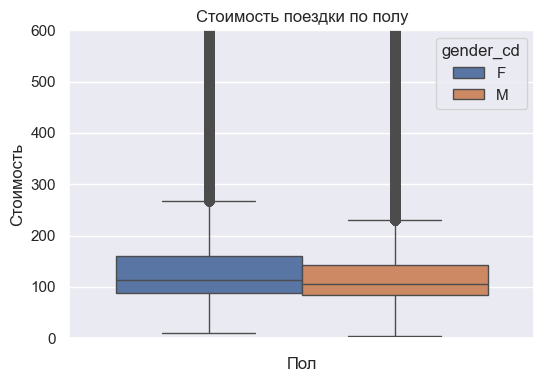

In [11]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_h1, hue='gender_cd', y='nominal_price_rub_amt')
plt.title('Стоимость поездки по полу')
plt.xlabel('Пол')
plt.ylabel('Стоимость')
plt.ylim(0, 600)
plt.show()

**Анализ:**

На графике можно увидеть, что распределение средней стоимости поездок у мужчин и женщин различается. Видно, что медианная стоимость поездки у женщин немного выше, чем у мужчин. Границы box'а (который содержит 50% данных) расположены у женщин выше, чем у мужчин.

Так как данные распределены не нормально, то провели проверку с помощью U-теста Манна-Уитни вместо стандартного t-теста. Получили очень низкое значение p-value, которое _многократно меньше уровня значимости alpha = 0.05_. Следовательно, мы отвергаем нулевую гипотезу (H0) о том, что средняя стоимость поездки у мужчин выше или равна, чем у женщин. И принимаем альтернативную гипотезу, которая утверждает, что поездки у женщин **статистически значимо дороже**, чем у мужчин. Это не случайное колебание, а устойчивая разница в данных.

##### Гипотеза 2: H2 — Средняя длительность поездки больше у женщин, чем у мужчин

In [12]:
df_h2 = df[df['gender_cd'].isin(['M', 'F'])][['gender_cd', 'trip_duration_min']].copy()
df_h2['gender_cd'] = df_h2['gender_cd'].cat.remove_unused_categories()

In [13]:
# выборки для теста
female_duration = df_h2[df_h2['gender_cd'] == 'F']['trip_duration_min']
male_duration = df_h2[df_h2['gender_cd'] == 'M']['trip_duration_min']

print(f"Поездки F: {len(female_duration)}, поездки M: {len(male_duration)}")

Поездки F: 51827, поездки M: 297850


In [14]:
# проверка на нормальное распределение данных

nt_f = stats.normaltest(female_duration)
nt_m = stats.normaltest(male_duration)

print(f"Normaltest (F) p-value: {nt_f.pvalue:.3e}")
print(f"Normaltest (M) p-value: {nt_m.pvalue:.3e}")

Normaltest (F) p-value: 0.000e+00
Normaltest (M) p-value: 0.000e+00


Данные не нормальные, используем Mann-Whitney U-test.

In [15]:
# H0: F <= M
# H1 (альтернативная гипотеза): F > M
stat, p_val = stats.mannwhitneyu(female_duration, male_duration, alternative='greater')

print(f"Тест: Mann–Whitney U-test")
print(f"P-value: {p_val:.3e}")

Тест: Mann–Whitney U-test
P-value: 3.357e-250


In [16]:
if p_val < ALPHA:
    print(f"Вывод: гипотеза H0 отвергается. Средняя длительность поездки у женщин статистически значимо выше, чем у мужчин (p < {ALPHA}).")
else:
    print(f"Вывод: гипотеза H0 не отвергается. Нет оснований полагать, что женщины ездят дольше (p >= {ALPHA}).")

Вывод: гипотеза H0 отвергается. Средняя длительность поездки у женщин статистически значимо выше, чем у мужчин (p < 0.05).


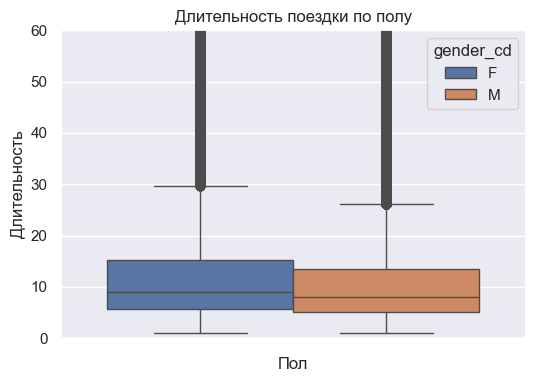

In [17]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_h2, hue='gender_cd', y='trip_duration_min')
plt.title(f'Длительность поездки по полу')
plt.xlabel('Пол')
plt.ylabel('Длительность')
plt.ylim(0, 60)
plt.show()

**Анализ:**

График boxplot подтверждает наблюдение из EDA: медианная длительность поездки у женщин выше, чем у мужчин.

Данные не нормальные. Применили U-тест Манна-Уитни, чтобы проверить гипотезу и получили значение p-value, которое _кратно меньше уровня значимости alpha = 0.05_. Отвергаем нулевую гипотезу (H0) — предварительные выводы из EDA **статистически подтверждены**. Женщины действительно (статистически значимо) совершают более длительные поездки, чем мужчины.

Гипотеза 1 тесно связана с гипотезой 2 — из-за того, что у женщин поездки длиннее, они и получаются дороже. Причём, как было замечено в EDA и SQL-анализе, средняя дистанция почти одинакова. Это говорит о меньшей средней скорости женщин, которые катаются более аккуратно и осторожно.

##### Гипотеза 3: H3 — Поездки в выходные дни дороже, чем в будние

In [18]:
df_h3 = df[['day_of_week', 'nominal_price_rub_amt']].copy()

# создаем категорию day_type из day_of_week (где 0-пн)
df_h3['day_type'] = np.where(df_h3['day_of_week'].isin([5, 6]), 'Weekend', 'Weekday')

In [19]:
# выборки
weekend_prices = df_h3[df_h3['day_type'] == 'Weekend']['nominal_price_rub_amt']
weekday_prices = df_h3[df_h3['day_type'] == 'Weekday']['nominal_price_rub_amt']

print(f"Поездки (weekend): {len(weekend_prices)}, поездки (weekday): {len(weekday_prices)}")

Поездки (weekend): 90573, поездки (weekday): 261709


In [20]:
# проверка на нормальное распределение данных

nt_wend = stats.normaltest(weekend_prices)
nt_wday = stats.normaltest(weekday_prices)

print(f"Normaltest (weekend) p-value: {nt_wend.pvalue:.3e}")
print(f"Normaltest (weekday) p-value: {nt_wday.pvalue:.3e}")

Normaltest (weekend) p-value: 0.000e+00
Normaltest (weekday) p-value: 0.000e+00


Данные не нормальные, используем тест Манна-Уитни.

In [21]:
# H0: Weekend <= Weekday
# H1 (альтернативная гипотеза): Weekend > Weekday
stat, p_val = stats.mannwhitneyu(weekend_prices, weekday_prices, alternative='greater')

print(f"Тест: Mann–Whitney U-test")
print(f"P-value: {p_val:.3e}")

Тест: Mann–Whitney U-test
P-value: 0.000e+00


In [22]:
if p_val < ALPHA:
    print(f"Вывод: гипотеза H0 отвергается. Поездки в выходные дни статистически значимо дороже, чем в будние дни (p < {ALPHA}).")
else:
    print(f"Вывод: гипотеза H0 не отвергается. Нет статистически значимых оснований полагать, что в выходные дни поездки дороже (p >= {ALPHA}).")

Вывод: гипотеза H0 отвергается. Поездки в выходные дни статистически значимо дороже, чем в будние дни (p < 0.05).


Наблюдение из EDA о разнице средней стоимости поездок в выходные и в будние дни подтвердилось.

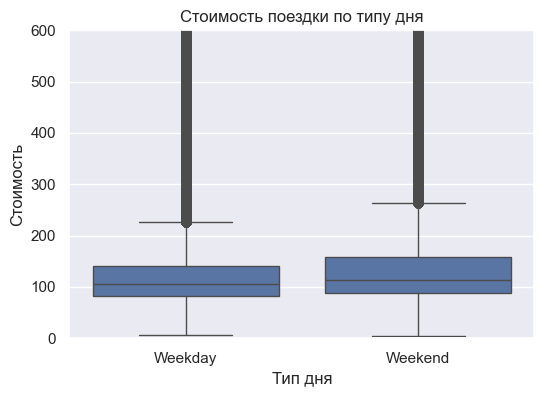

In [23]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_h3, x='day_type', y='nominal_price_rub_amt', order=['Weekday', 'Weekend'])
plt.title(f'Стоимость поездки по типу дня')
plt.xlabel('Тип дня')
plt.ylabel('Стоимость')
plt.ylim(0, 600)
plt.show()

**Анализ:**

График boxplot наглядно подтверждает выводы из EDA: медианная стоимость и весь интерквартильный размах (IQR) для поездок в выходные заметно смещены вверх по сравнению с будними.

Данные о стоимости, как и в предыдущих гипотезах, не распределены нормально. Применили U-тест Манна-Уитни для проверки гипотезы: Weekend > Weekday. Получили _значение p-value < alpha (alpha = 0.05)_. Следовательно, отвергаем нулевую гипотезу (H0). Наблюдение о том, что поездки в выходные дни дороже, **статистически подтверждено**.

У нас есть статистическое обоснование для введения специальных тарифов, так как пользователи уже де-факто платят больше.

##### Гипотеза 4: H4 — Возраст влияет на среднюю стоимость поездки

In [24]:
df_h4 = df.groupby('party_rk').agg(
    # укажем максимальное значение для возраста пользователя (может измениться за полгода)
    age=('age', 'max'),
    avg_ride_cost=('nominal_price_rub_amt', 'mean')
).reset_index()

# выборки
age = df_h4['age']
cost = df_h4['avg_ride_cost']

print(f"Количество пользователей для анализа: {len(age)}")

Количество пользователей для анализа: 57170


In [25]:
# проведение тестов корреляции
pearson_corr, pearson_p = stats.pearsonr(age, cost)
spearman_corr, spearman_p = stats.spearmanr(age, cost)

# H0: возраст не влияет на стоимость
# H1 (альтернативная гипотеза): возраст влияет на стоимость

print("Корреляция:")
print(f"Pearson r (линейная): {pearson_corr:.4f}, p-value: {pearson_p:.3e}")
print(f"Spearman rs (монотонная): {spearman_corr:.4f}, p-value: {spearman_p:.3e}")

Корреляция:
Pearson r (линейная): 0.0809, p-value: 1.110e-83
Spearman rs (монотонная): 0.1048, p-value: 2.665e-139


In [26]:
# линейная регрессия (OLS)
X = sm.add_constant(age)
model = sm.OLS(cost, X).fit()

print(model.summary())

# вывод ключевых метрик
r_squared = model.rsquared
beta_age = model.params['age']
p_value_OLS = model.pvalues['age']

print(f"\nКоэффициент детерминации (R-squared): {r_squared:.4f}")
print(f"Коэффициент возраста (beta age): {beta_age:.4f}")
print(f"P-value для возраста (OLS): {p_value_OLS:.3e}")

                            OLS Regression Results                            
Dep. Variable:          avg_ride_cost   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     376.9
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           1.11e-83
Time:                        00:58:14   Log-Likelihood:            -3.5160e+05
No. Observations:               57170   AIC:                         7.032e+05
Df Residuals:                   57168   BIC:                         7.032e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        127.1864      1.664     76.415      0.0

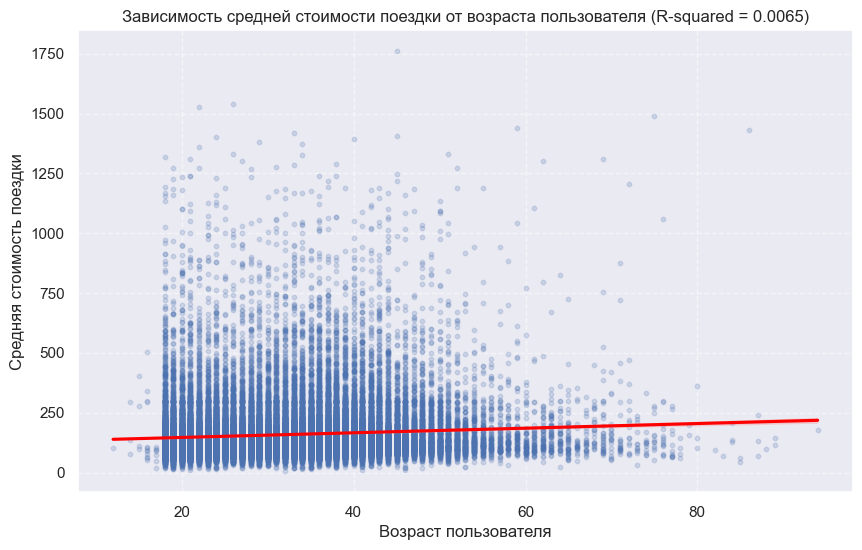

In [27]:
plt.figure(figsize=(10, 6))
sns.regplot(x=age, y=cost, scatter_kws={'alpha': 0.2, 's': 10}, line_kws={'color': 'red'}, ci=100)
plt.title(f'Зависимость средней стоимости поездки от возраста пользователя (R-squared = {r_squared:.4f})')
plt.xlabel('Возраст пользователя')
plt.ylabel('Средняя стоимость поездки')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [28]:
if p_value_OLS < ALPHA:
    print(f"Вывод: гипотеза H0 отвергается. Связь статистически значима (p-value < {ALPHA}).")
else:
    print(f"Вывод: гипотеза H0 не отвергается. Линейная связь не является статистически значимой.")

Вывод: гипотеза H0 отвергается. Связь статистически значима (p-value < 0.05).


**Анализ:**

Обнаружена **статистически значимая, но очень слабая положительная корреляция** между возрастом пользователя и средней стоимостью его поездок: _Пирсон $r = 0.0809$, Спирмен $r_s = 0.1048$_. _Коэффициент детерминации ($R^2 = 0.0065$)_ показывает, что изменения в возрасте объясняют менее 1%, а именно 0.65% изменений средней стоимости. Увеличение возраста на 1 год связано с увеличением средней стоимости поездки на 0.97 рублей.

Возраст слабо влияет на стоимость поездки. Старшие пользователи платят немного больше, но эта разница не имеет бизнес-значения, так как они совершают намного меньше поездок. Для повышения средней стоимости или вовлечённости целесообразнее ориентироваться на поведенческие факторы.

##### Гипотеза 5: H5 — Мужчины совершают больше поездок на пользователя, чем женщины

In [29]:
df_h5 = df[df['gender_cd'].isin(['M', 'F'])].copy()
df_h5['gender_cd'] = df_h5['gender_cd'].cat.remove_unused_categories()

# для каждого пользователя укажем пол и посчитаем количество его поездок
user_rides = df_h5.groupby(['party_rk', 'gender_cd'], observed=True)['order_rk'].count().reset_index()
user_rides.rename(columns={'order_rk': 'rides_count'}, inplace=True)

In [30]:
# выборки
female_rides_per_user = user_rides[user_rides['gender_cd'] == 'F']['rides_count']
male_rides_per_user = user_rides[user_rides['gender_cd'] == 'M']['rides_count']

print(f"Пользователи F: {len(female_rides_per_user)}, пользователи M: {len(male_rides_per_user)}")

Пользователи F: 10622, пользователи M: 46117


In [31]:
# проверка на нормальное распределение данных

nt_f = stats.normaltest(female_rides_per_user)
nt_m = stats.normaltest(male_rides_per_user)

print(f"Normaltest (F) p-value: {nt_f.pvalue:.3e}")
print(f"Normaltest (M) p-value: {nt_m.pvalue:.3e}")

Normaltest (F) p-value: 0.000e+00
Normaltest (M) p-value: 0.000e+00


Данные распределены не нормально.

In [32]:
# H0: M <= F
# H1: M > F

stat, p_val = stats.mannwhitneyu(male_rides_per_user, female_rides_per_user, alternative='greater')

print(f"Тест: Mann–Whitney U-test")
print(f"P-value: {p_val:.3e}")

Тест: Mann–Whitney U-test
P-value: 5.209e-67


In [33]:
if p_val < ALPHA:
    print(f"Вывод: гипотеза H0 отвергается. Разница в вовлечённости (rides per user) статистически значима (p < {ALPHA}).")
    print(f"Данные (M = 6.46, F = 4.88), найденные в EDA и SQL-анализе подтверждают, что мужчины в среднем ездят чаще.")
else:
    print(f"Вывод: гипотеза H0 не отвергается. Разница не является статистически значимой (p >= {ALPHA}).")

Вывод: гипотеза H0 отвергается. Разница в вовлечённости (rides per user) статистически значима (p < 0.05).
Данные (M = 6.46, F = 4.88), найденные в EDA и SQL-анализе подтверждают, что мужчины в среднем ездят чаще.


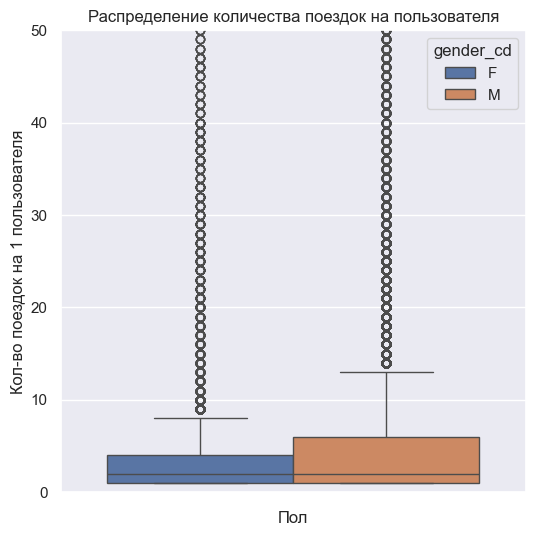

In [34]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=user_rides, hue='gender_cd', y='rides_count')
plt.title(f'Распределение количества поездок на пользователя')
plt.xlabel('Пол')
plt.ylabel('Кол-во поездок на 1 пользователя')
plt.ylim(0, 50)
plt.show()

**Анализ:**

Медианное значение поездок на пользователя почти совпадает (что видно на графике), однако среднее количество поездок на пользователя у мужчин значимо выше, чем у женщин.

Значение _p-value меньше уровня alpha (alpha = 0.05)_, следовательно, отвергаем гипотезу H0. Мужчины совершают **статистически значимо больше** поездок на пользователя, чем женщины (p-value < 0.05). Рекомендация: учитывать половую принадлежность при разработке программ лояльности и маркетинговых кампаний, направленных на увеличение частоты поездок.

##### Гипотеза 6: H6 — существует различие в проценте вернувшихся пользователей

In [35]:
df_h6 = df[df['gender_cd'].isin(['M', 'F'])].copy()
df_h6['gender_cd'] = df_h6['gender_cd'].cat.remove_unused_categories()

user_rides_count = df_h6.groupby('party_rk')['order_rk'].count().reset_index()
user_rides_count.rename(columns={'order_rk': 'rides_count'}, inplace=True)

In [36]:
# метка для retention (0 - не вернулся, 1 - совершил 2+ поездки)
user_rides_count['is_returned'] = (user_rides_count['rides_count'] >= 2).astype(int)

In [37]:
user_gender = df_h6[['party_rk', 'gender_cd']].drop_duplicates()
df_chi = user_rides_count.merge(user_gender, on='party_rk', how='left')

contingency_table = pd.crosstab(df_chi['gender_cd'], df_chi['is_returned'])

In [38]:
contingency_table.columns = ['Не вернулся (1 поездка)', 'Вернулся (2+ поездки)']
contingency_table.index.name = 'Пол'

contingency_table

,Не вернулся (1 поездка),Вернулся (2+ поездки)
Пол,,
F,4885,5737
M,17831,28286


In [39]:
# тест Хи-квадрат
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Тест: Chi-squared Test")
print(f"Статистика Chi2: {chi2:.4f}")
print(f"Степени свободы (dof): {dof}")
print(f"P-value: {p_val:.3e}")

Тест: Chi-squared Test
Статистика Chi2: 192.6388
Степени свободы (dof): 1
P-value: 8.440e-44


In [40]:
if p_val < ALPHA:
    # процентное соотношение вернувшихся для каждого пола
    retention_rates = contingency_table.apply(lambda x: x / x.sum(), axis=1)

    male_return_rate = retention_rates.loc['M']['Вернулся (2+ поездки)']
    female_return_rate = retention_rates.loc['F']['Вернулся (2+ поездки)']

    print(f"Доля вернувшихся F: {female_return_rate:.2%}")
    print(f"Доля вернувшихся M: {male_return_rate:.2%}")

    print(f"\nВывод: гипотеза H0 отвергается. Существует статистически значимое различие в проценте вернувшихся пользователей (p < {ALPHA}).")
    if male_return_rate > female_return_rate:
        print(f"Мужчины возвращаются значимо чаще, чем женщины.")
    else:
        print(f"Женщины возвращаются значимо чаще, чем мужчины.")

else:
    print(f"\nВывод: гипотеза H0 не отвергается. Разница в пропорциях возврата не является статистически значимой (p >= {ALPHA}).")

Доля вернувшихся F: 54.01%
Доля вернувшихся M: 61.34%

Вывод: гипотеза H0 отвергается. Существует статистически значимое различие в проценте вернувшихся пользователей (p < 0.05).
Мужчины возвращаются значимо чаще, чем женщины.


**Анализ:**

Мужчины возвращаются значимо чаще, чем женщины. Это значит, что мужчины более склонны формировать привычку пользоваться сервисом в долгую. Мужчины формируют лояльность быстрее, возможно потому что используют самокат как часть постоянных маршрутов (до метро, до работы и т.п.).

У женщин 54% retention, значит сервис теряет каждую вторую. А это большой резерв для роста активной базы и выручки. Повышение удержания женщин даст огромный прирост revenue, так как сейчас они делают меньше поездок на пользователя, реже возвращаются, но при этом их средняя стоимость поездки выше. Нужно улучшить безопасность, UX и персонализированные промо, чтобы повысить retention женщин.

### Анализ статистических гипотез

**1. Женщины совершают статистически значимо более дорогие и длительные поездки.**

Гипотезы H1 и H2 подтвердились: стоимость поездок у женщин выше; длительность поездок у женщин также больше.

Женщины — важный, но недоиспользованный сегмент: хотя они совершают меньше поездок, каждая поездка приносит больше дохода. Причина: более длительные поездки при той же дистанции — более аккуратный и осторожный стиль езды. Это открывает потенциал для таргетированных кампаний, направленных именно на женскую аудиторию.

**2. Поездки в выходные статистически значимо дороже.**

Гипотеза H3 полностью подтверждена. Пользователи платят больше в выходные независимо от пола.

Сервис может вводить специальные выходные тарифы и усилить маркетинг именно по выходным.

**3. Возраст влияет на стоимость крайне слабо.**

Гипотеза H4 частично подтверждена: связь есть, но она очень слабая (Пирсон ~0.08, Спирмен ~0.10); возраст объясняет всего 0.65% вариации стоимости поездки.

Возраст не стоит использовать как основу для тарифов или сегментации.

**4. Мужчины ездят чаще и формируют лояльность быстрее.**

Гипотеза H5 подтвердилась: мужчины совершают статистически значимо больше поездок на пользователя (p < 0.05). Гипотеза H6 также подтвердилась: retention женщин: 54.0%, retention мужчин: 61.3%.

Мужчины быстрее формируют привычку пользоваться сервисом; женщины чаще отказываются от сервиса после 1–2 поездок, однако приносят больше дохода за одну поездку — но возвращаются реже.

### Вывод

1. Женщины совершают более дорогие и длительные поездки, но возвращаются реже (**retention 54% против 61%**). Это критический источник упущенной выручки.
2. Женская аудитория — ключевая точка роста. Увеличение retention женщин даст ощутимый рост revenue, так как их чек выше.
3. В выходные дни пользователи готовы платить больше, что создаёт потенциал для адаптивных тарифов или акций.
4. Возраст почти не влияет на стоимость, поэтому возрастная сегментация малоэффективна.
5. Половая принадлежность — важный фактор поведения, который стоит учитывать в маркетинге, промо-механиках и удержании.